<a href="https://colab.research.google.com/github/GyuhoonK/munhwa_bigdata/blob/master/tf_idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
##Colab 실행 시, plot에 필요한 한글 font를 설치합니다.
#local에서 실행할 경우, 다른 경로를 지정해야합니다.

#Setting matplot possible type Korean
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
import pickle
import os
import glob

from unicodedata import normalize
import numpy as np
import pandas as pd
import re
from collections import defaultdict
from tqdm import tqdm_notebook
import datetime

import matplotlib.pyplot as plt

from math import ceil

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#DATA_PATH : 기본 경로입니다. ipynb 파일이 저장된 폴더 경로를 지정해주세요
DATA_PATH = '/content/gdrive/My Drive/Colab Notebooks/munhwa_bigdata'
#PKL_PATH : pkl 파일이 저장된 경로를 지정해주세요
PKL_PATH = os.path.join(DATA_PATH, 'pkl')
#POS_PATH : 형태소 분석 결과를 저장할 폴더 경로를 지정해주세요
SAVE_PATH = os.path.join(DATA_PATH, 'pos')
SHINHAN_PATH = '/content/gdrive/My Drive/Colab Notebooks/munhwa_bigdata/shinhan'

In [ ]:
POS_FILE = glob.glob(os.path.join(SAVE_PATH, '*.pkl'))
POS_NAME = list(map(lambda x : os.path.basename(x), POS_FILE))
CITY = list(map(lambda x : x.split('.')[0], POS_NAME))
CITY = list(map(lambda x : normalize('NFC', x), CITY))
id_to_title = {i : j for i , j in enumerate(CITY)}

In [ ]:
raw_doc = {}
for pos in POS_FILE:
  with open(pos, 'rb') as f:
    pos_ = pickle.load(f)
    raw_doc.update(pos_)
  f.close()

In [ ]:
stop_words = ['여행']
for words in list(map(lambda x : x.split(' ')[:-1], CITY)):
  for word in words :
    if not word in stop_words:
      stop_words.append(word)
stop_words = list(map(lambda x : normalize('NFC', x), stop_words))  #구글드라이브 경로에서 파일 이름이 자음+모음으로 분해되어서 normalize 필요 
stop_words += ['강원도', '경기도', '전라도', '경상도', '충청도']
stop_words += ['사진', '시간']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

MAX_FEATURE = 250

vectorizer = TfidfVectorizer(max_features=MAX_FEATURE,
                             stop_words = stop_words)



X = vectorizer.fit_transform(raw_doc.values())
tf_idf = pd.DataFrame(X.todense())
tf_idf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
0,0.051293,0.066278,0.037269,0.029393,0.109502,0.074538,0.029393,0.038230,0.067814,0.066085,0.040919,0.023821,0.082991,0.033619,0.050140,0.027856,0.024590,0.035348,0.016713,0.022669,0.027087,0.064933,0.130634,0.031506,0.065125,0.085104,0.013256,0.037461,0.028240,0.046106,0.021516,0.055327,0.096631,0.114305,0.058977,0.026895,0.051869,0.041495,0.024014,0.052830,...,0.054943,0.067622,0.056864,0.037269,0.032082,0.025166,0.115265,0.057633,0.036885,0.158874,0.217083,0.010566,0.090675,0.100473,0.013640,0.047451,0.048219,0.027856,0.043224,0.043801,0.033235,0.036885,0.035540,0.031122,0.034772,0.046682,0.039767,0.050140,0.004803,0.034195,0.026249,0.033235,0.055135,0.034003,0.020940,0.051485,0.034003,0.025743,0.030737,0.039382
1,0.029165,0.049029,0.019076,0.024120,0.077406,0.071415,0.029165,0.082766,0.085288,0.057227,0.033895,0.031530,0.077879,0.065740,0.041935,0.021756,0.024120,0.025697,0.010720,0.024120,0.024278,0.052182,0.084658,0.051709,0.243410,0.149609,0.015607,0.043196,0.018603,0.026327,0.020652,0.042565,0.068262,0.067001,0.035944,0.029165,0.033422,0.027116,0.022071,0.043984,...,0.069366,0.057857,0.155127,0.032791,0.029953,0.035629,0.061483,0.093328,0.028377,0.136524,0.133686,0.045718,0.050605,0.172153,0.023332,0.057857,0.092225,0.009932,0.026800,0.095378,0.063533,0.028219,0.035156,0.063060,0.027116,0.049502,0.069050,0.032633,0.007410,0.030742,0.002651,0.031215,0.068577,0.034052,0.019076,0.039255,0.023174,0.048556,0.049344,0.030426
2,0.040729,0.066282,0.019048,0.032522,0.076813,0.083627,0.032831,0.079755,0.071547,0.055132,0.030353,0.024778,0.092919,0.037167,0.073870,0.024623,0.026017,0.033760,0.009292,0.021836,0.021526,0.078981,0.090596,0.017190,0.268690,0.062101,0.010686,0.043362,0.028340,0.039955,0.020442,0.060707,0.080839,0.111193,0.052499,0.030973,0.044601,0.034535,0.018893,0.045840,...,0.031592,0.058229,0.091990,0.042743,0.029734,0.043052,0.073251,0.037787,0.018893,0.136126,0.206434,0.067366,0.068915,0.110728,0.016106,0.036393,0.068605,0.004646,0.024469,0.069534,0.036083,0.038716,0.031438,0.167718,0.040575,0.046924,0.051105,0.039026,0.010995,0.032831,0.003255,0.039645,0.060087,0.026482,0.020907,0.024933,0.024778,0.029269,0.025862,0.034690
3,0.045066,0.085160,0.018283,0.029830,0.110660,0.063670,0.042981,0.063028,0.075217,0.060462,0.029990,0.019566,0.062868,0.039934,0.042179,0.020849,0.023255,0.040736,0.006094,0.012670,0.021490,0.101358,0.098311,0.017481,0.101198,0.050519,0.039934,0.038490,0.034641,0.034000,0.018764,0.060462,0.098151,0.111783,0.052283,0.034962,0.043462,0.041858,0.024538,0.053566,...,0.041056,0.066236,0.146424,0.018604,0.024698,0.022292,0.065915,0.069122,0.018443,0.119320,0.189886,0.009302,0.089330,0.042339,0.012830,0.050519,0.016038,0.010585,0.033839,0.034641,0.044585,0.039292,0.031915,0.023094,0.029349,0.066396,0.039613,0.035764,0.002726,0.032556,0.000000,0.035443,0.068481,0.034802,0.013953,0.096066,0.037528,0.027424,0.014274,0.033839
4,0.064607,0.091374,0.016689,0.028255,0.102445,0.050231,0.052049,0.051553,0.072042,0.066920,0.031394,0.016358,0.052544,0.041969,0.038334,0.016523,0.024950,0.034038,0.004296,0.012723,0.023628,0.164408,0.083608,0.047753,0.100793,0.019498,0.021480,0.044778,0.044448,0.030568,0.018837,0.086252,0.118638,0.121943,0.058162,0.028420,0.043952,0.038830,0.027594,0.049735,...,0.050396,0.054858,0.078321,0.025611,0.026603,0.027264,0.063119,0.064772,0.013880,0.112855,0.105585,0.012558,0.066259,0.067250,0.010905,0.049405,0.027264,0.008262,0.037508,0.042796,0.042796,0.035691,0.031064,0.029246,0.031394,0.074686,0.027098,0.039987,0.001322,0.034203,0.000347,0.033708,0.064441,0.040482,0.010905,0.042465,0.029081,0.040317,0.042135,0.035856


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


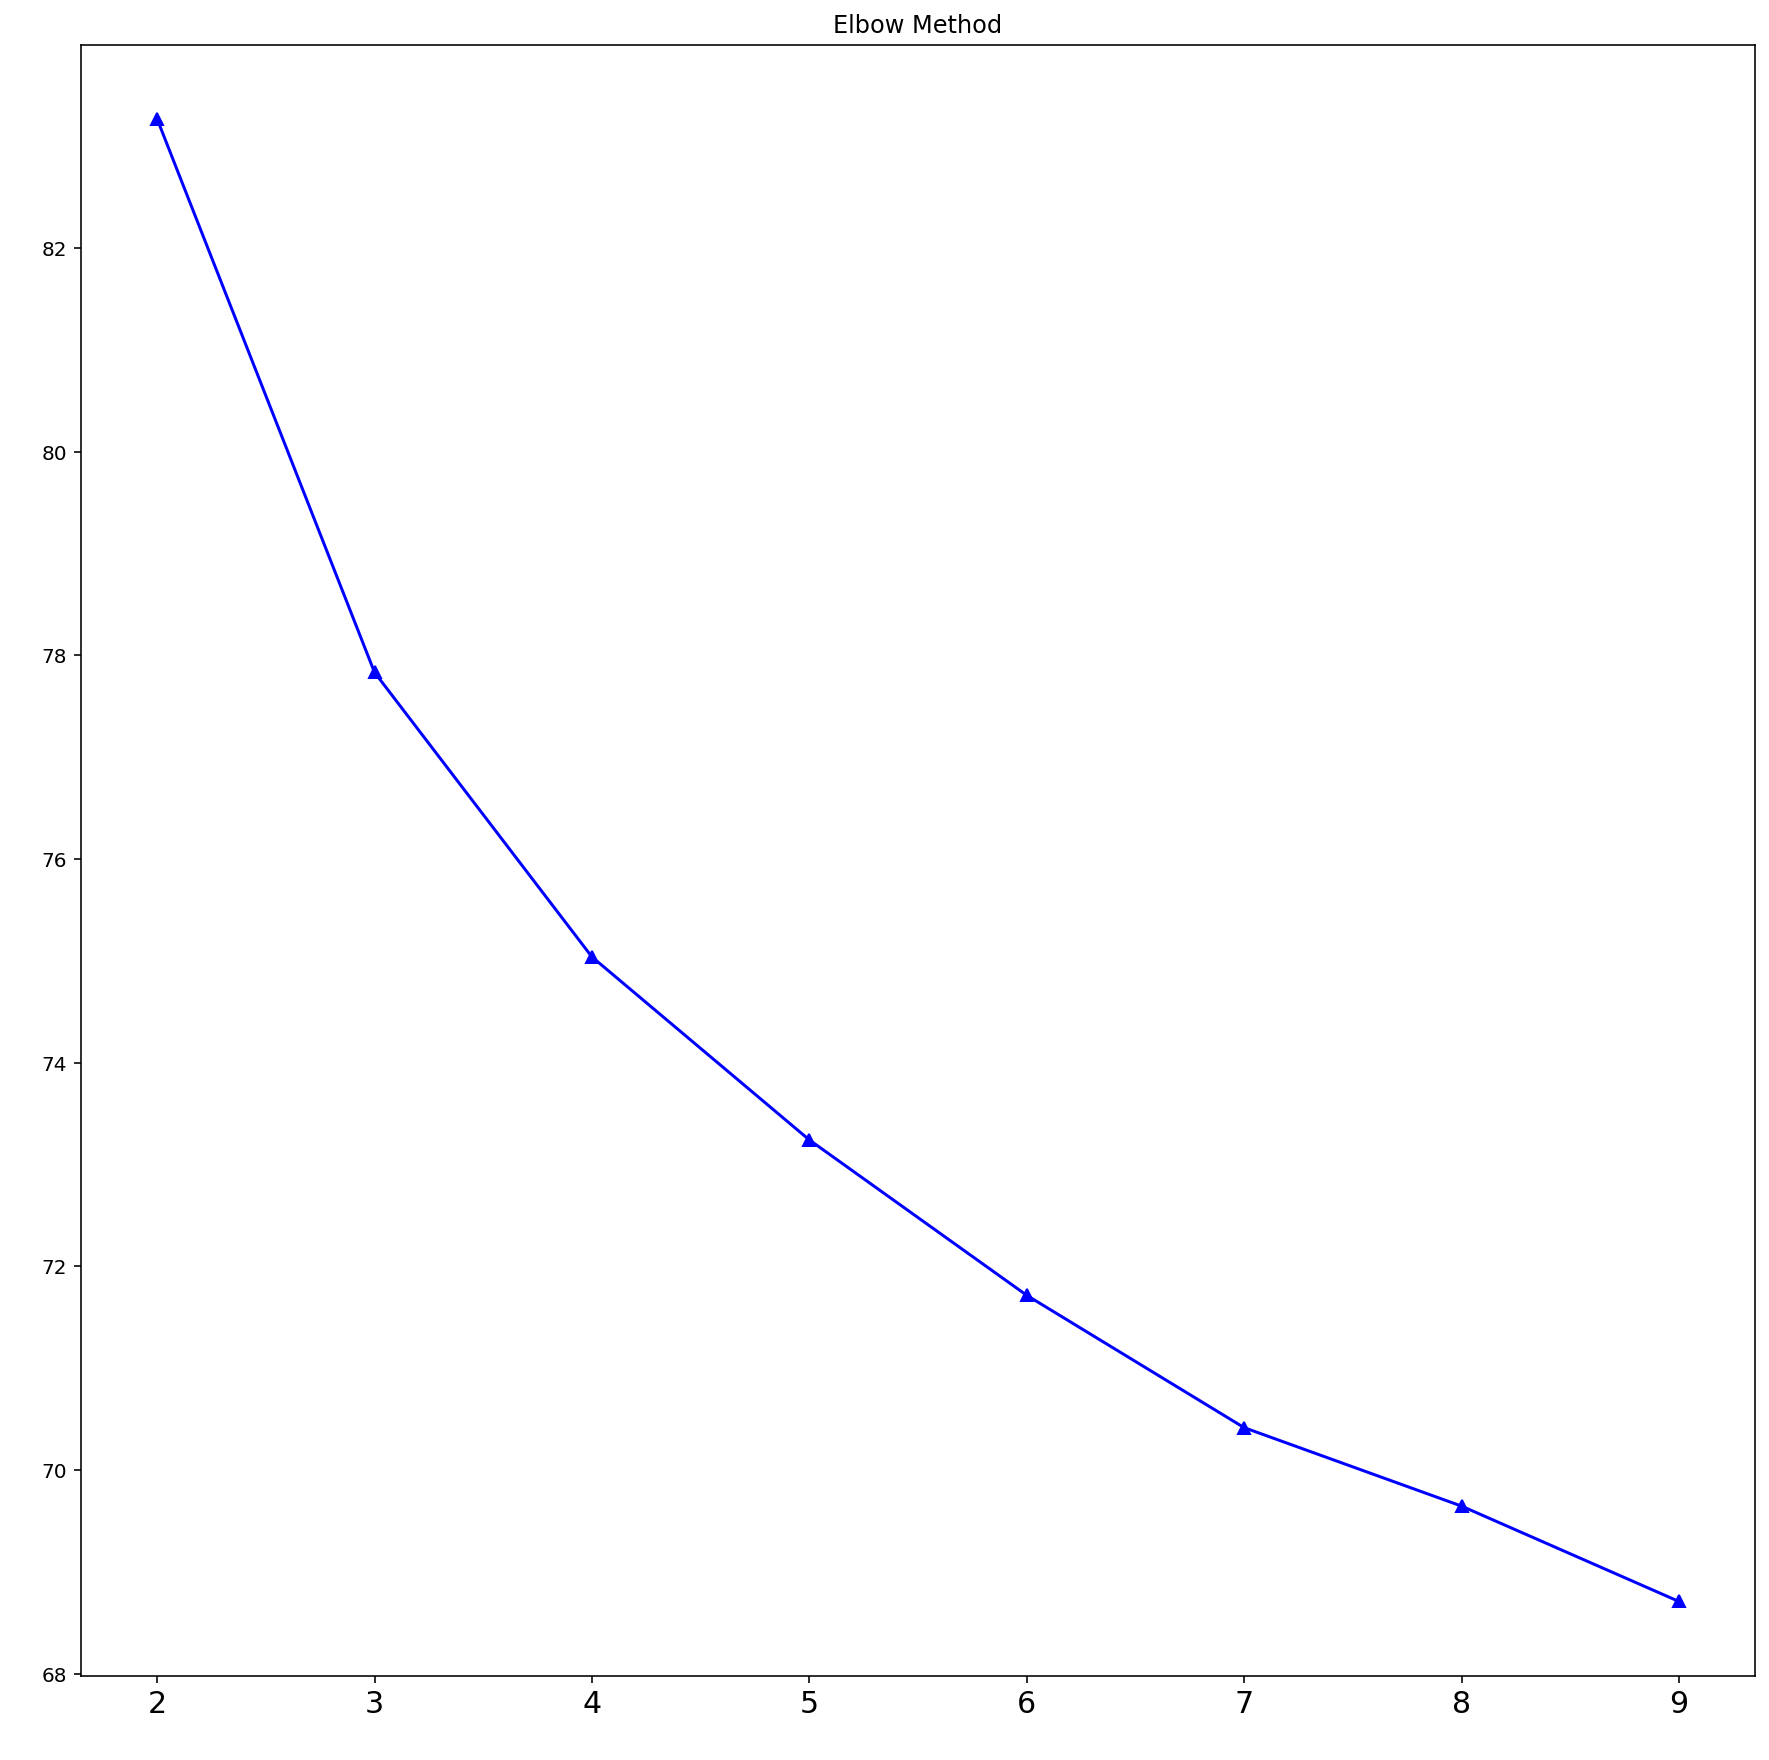

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

Dist = []
ran = range(2,10)
for K in tqdm_notebook(ran):
    kmeans = KMeans(n_clusters = K, 
                             random_state = 41,
                             n_jobs = -1).fit(tf_idf.values)
    distance = 0
    for point, label in zip(tf_idf.values, kmeans.labels_):
        distance += np.linalg.norm(kmeans.cluster_centers_[label] - point)
    Dist.append(distance)


plt.figure(figsize = (15,15))    
plt.plot(ran, Dist, color = 'b', marker = '^')
plt.xticks(ticks = ran, fontsize = 15)
plt.xlabel("Number of Cluster", color = 'white', fontsize = 10)
plt.ylabel("SSD", color = 'white', fontsize = 10)
plt.title("Elbow Method")
plt.show()

In [ ]:
def get_top_keywords(tf_idf, id_to_convert, clusters, labels, n_terms = 20):
    '''
    This function displays the top keywords based on tf-idf score.
    data = tf-idf array
    clusters = assigned cluster index
    labels = vectorizer.get_feature_names()
    n_terms = top n keywords
    '''
    #  based on predictions
    df = tf_idf.groupby(clusters).mean()
    cluster_label = [(i,j) for i, j in zip(tf_idf.index, clusters)]

    # loop through each clusters and print top 10 score words
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        print(','.join([id_to_convert[id] for id, lab in cluster_label if lab == i]))
        print('-' * 100)

def show_top_keywords(data, clusters, labels, n_terms = 20):
    '''
    This function displays the top keywords based on tf-idf score.
    data = tf-idf array
    clusters = assigned cluster index
    labels = vectorizer.get_feature_names()
    n_terms = top n keywords
    '''
    #  based on predictions
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    N = np.max(clusters)+1
    fig, axes = plt.subplots(ceil(N/3), 3, figsize = (30,15), sharey=True)
    axes_flattened = axes.flatten()
    
    for i,r in df.iterrows():
      x = [labels[t] for t in np.argsort(r)[-n_terms:]]
      y = np.sort(r)[-n_terms:][::-1]
      axes_flattened[i].bar(x, y, alpha = .5)
      axes_flattened[i].set_title('cluster {}'.format(i), fontsize = 20)
      axes_flattened[i].tick_params(labelsize = 13, labelrotation = 20)
      
def pnt(pct, allval):
  absolute = int(pct/100. * np.sum(allval))
  return "{:.1f}%\n{:d} cases".format(pct, absolute)
  
def show_plot_result(tf_idf, id_to_title, clusters):
  N = np.max(clusters)
  label_num, counts = np.unique(clusters, return_counts = True)
  labels = ['cluster ' + str(i) for i in label_num]
  fig, ax = plt.subplots(figsize = (10,10))
  wedges, texts, autotexts = ax.pie(counts, autopct = lambda pct : pnt(pct, counts),
                                    textprops = dict(color='w'))
  ax.legend(wedges, labels,
            title = 'Cluster labels',
            loc = 'center left',
            bbox_to_anchor = (1, 0, 0.5, 1))
  plt.setp(autotexts, size = 15, weight = 'bold')
  plt.show()


Cluster 0
그리,즐기,예쁘,마을,들어가,이렇,친구,정도,모습,가보,만들,맛있,코스,체험,카페,아이,생각,사람,보이,나오
담양 여행,오산 여행,영월 여행,순천 여행,무주 여행,광명 여행,군산 여행,남원 여행,서산 여행,양평 여행,당진 여행,김포 여행,남양주 여행,양산 여행,밀양 여행,부여 여행,경주 여행,구미 여행,단양 여행,원주 여행,인천 강화 여행,인제 여행,포천 여행,가평 여행,횡성 여행,화성 여행,홍천 여행,진주 여행,합천 여행,제천 여행,하동 여행,정선 여행,청주 여행,천안 여행,평창 여행,칠곡 여행,춘천 여행
----------------------------------------------------------------------------------------------------

Cluster 1
정도,메뉴,고기,주문,그리,오늘,위하,가능,이렇,위치,방문,만들,아이,사람,보이,친구,생각,카페,맛있,나오
부산 금정구 여행,대전 유성구 여행,대전 서구 여행,부산 부산진구 여행,부산 연제구 여행,부산 수영구 여행,부산 동래구 여행,부산 강서구 여행,서울 강남구 여행,서울 서초구 여행,광주 서구 여행,광주 동구 여행,광주 광산구 여행,광주 북구 여행,대구 동구 여행,대구 수성구 여행,대구 북구 여행,대구 남구 여행,대구 서구 여행,대구 달서구 여행,울산 북구 여행,의정부 여행,인천 남동구 여행,인천 계양구 여행,인천 서구 여행,인천 부평구 여행,인천 미추홀구 여행,하남 여행
----------------------------------------------------------------------------------------------------

Cluster 2
카페,다리,문화,축제,코스,즐기,가보,위하,마을,박물관,친구,모습,생각,나오,만들,아이,사람,보이,공원,체험
세종 여행,예산 여행,양구 여행,여주 여행,고양 여행,과천 여행,양주 여행,수원 여행,시흥 여행,부천 여행,논산 여행,안산 여행,용인 여행,연천 여행,김해 여행,상주

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44536 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47532 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51600 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44592 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 50696 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 49240 missing from current font.

/usr/local/lib/pyt

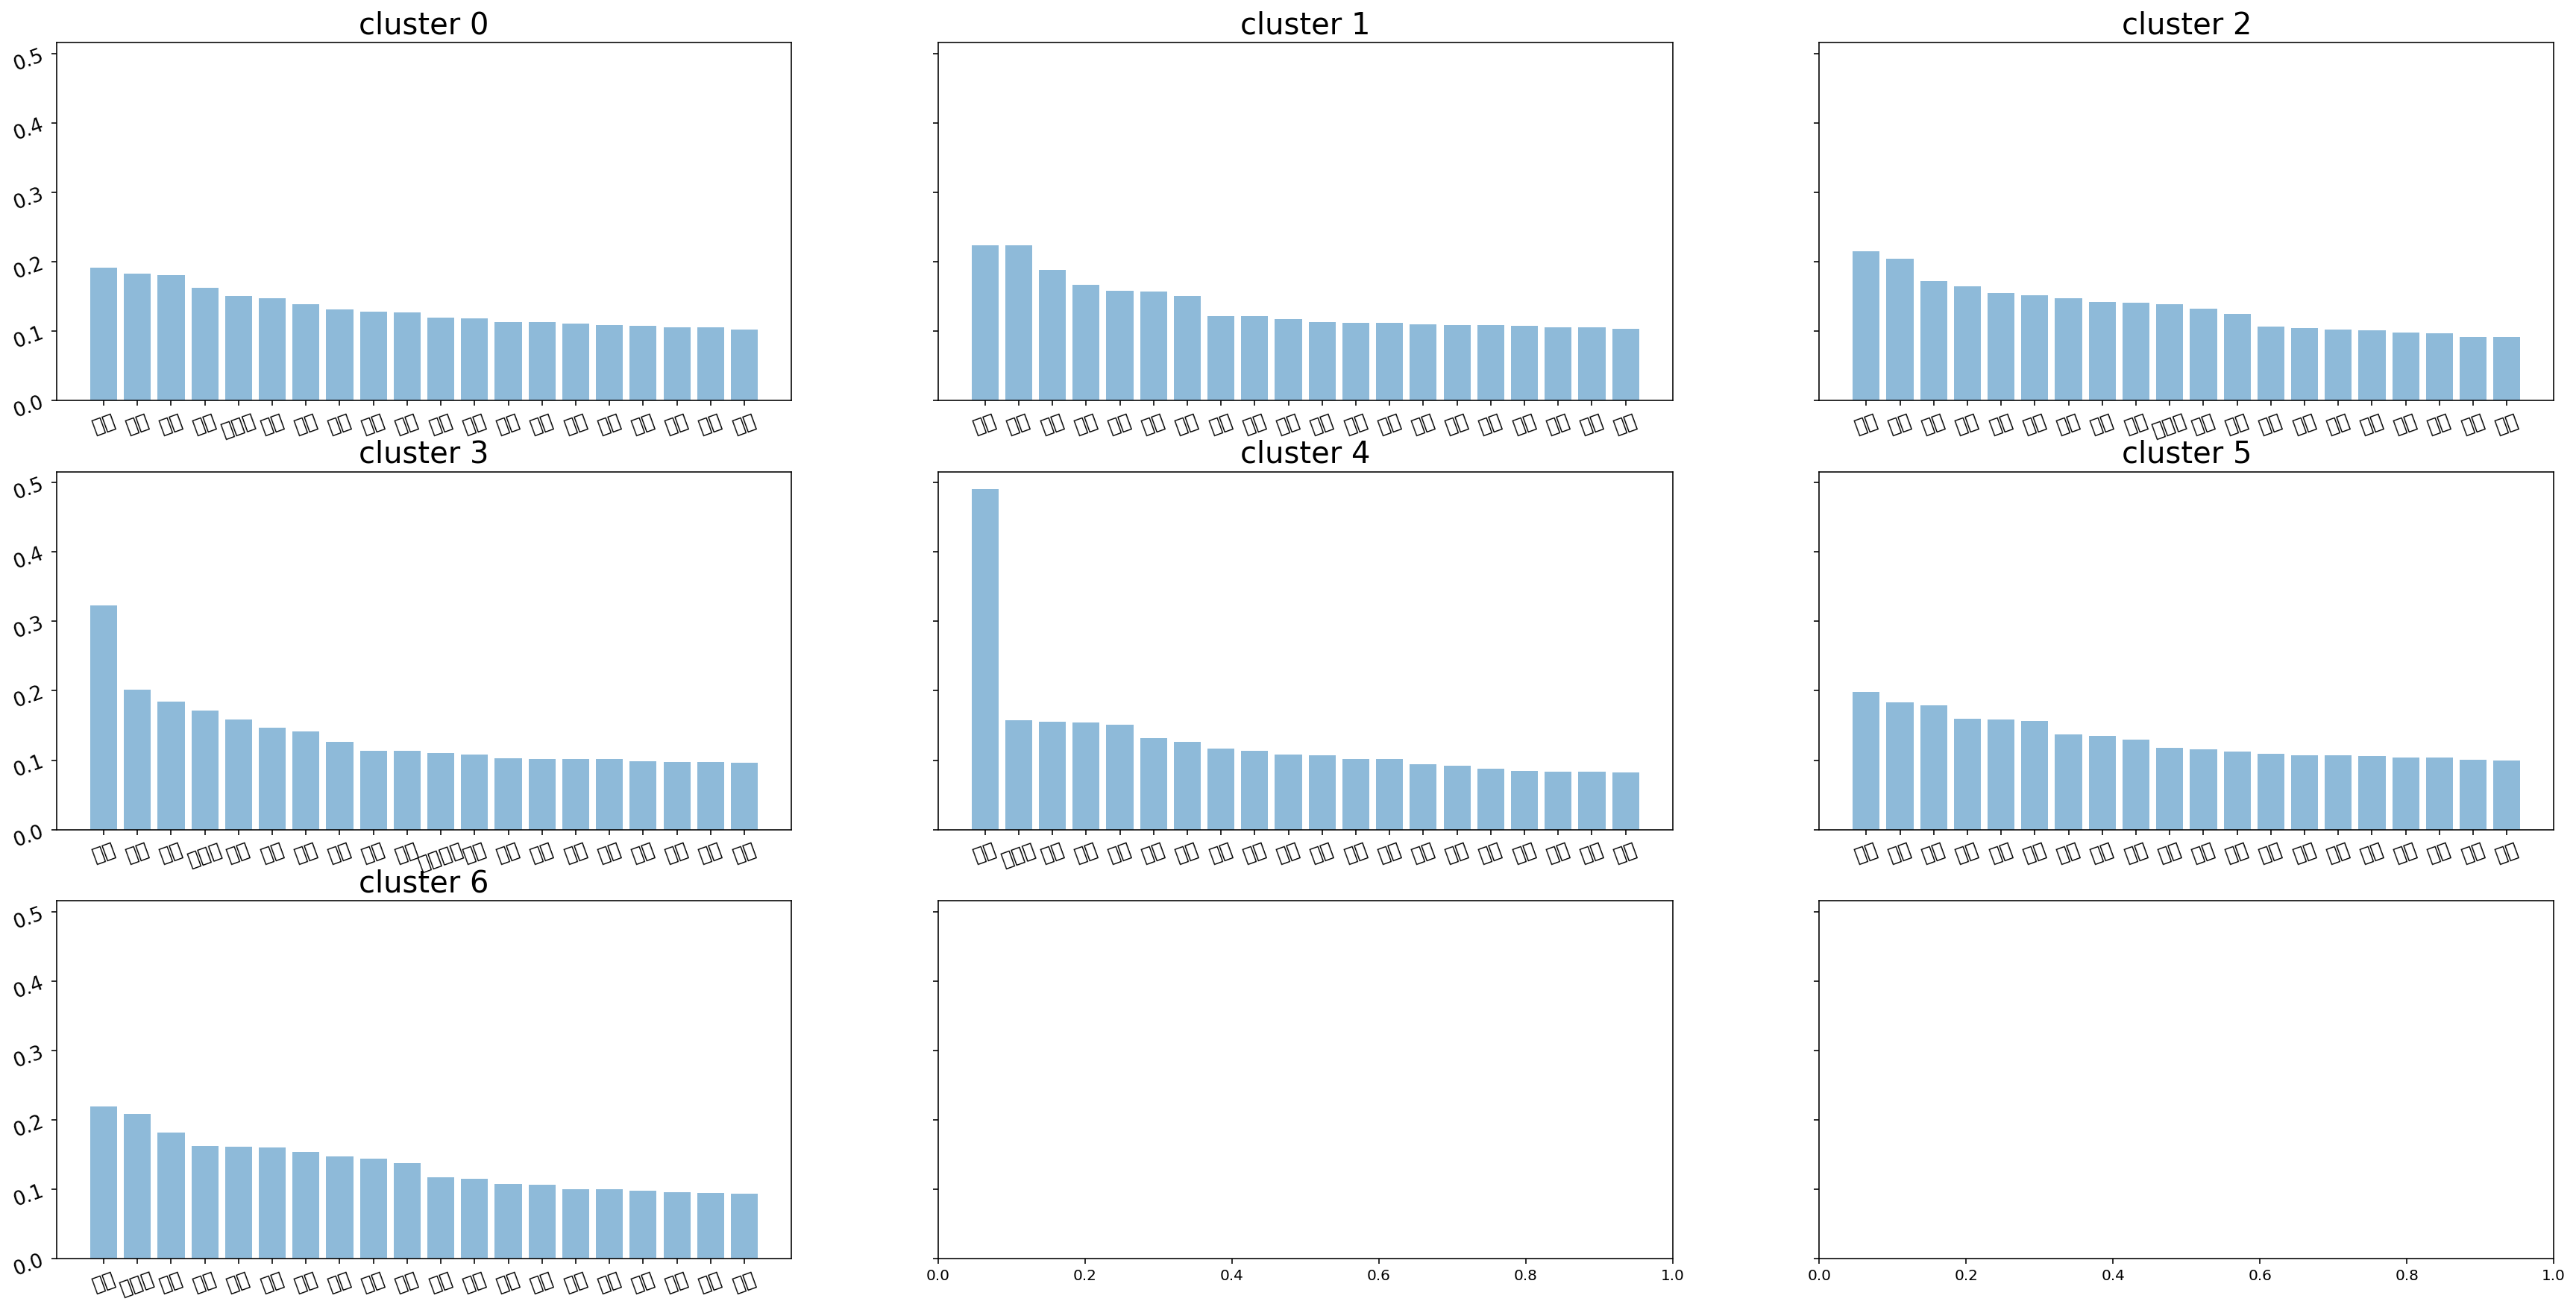

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


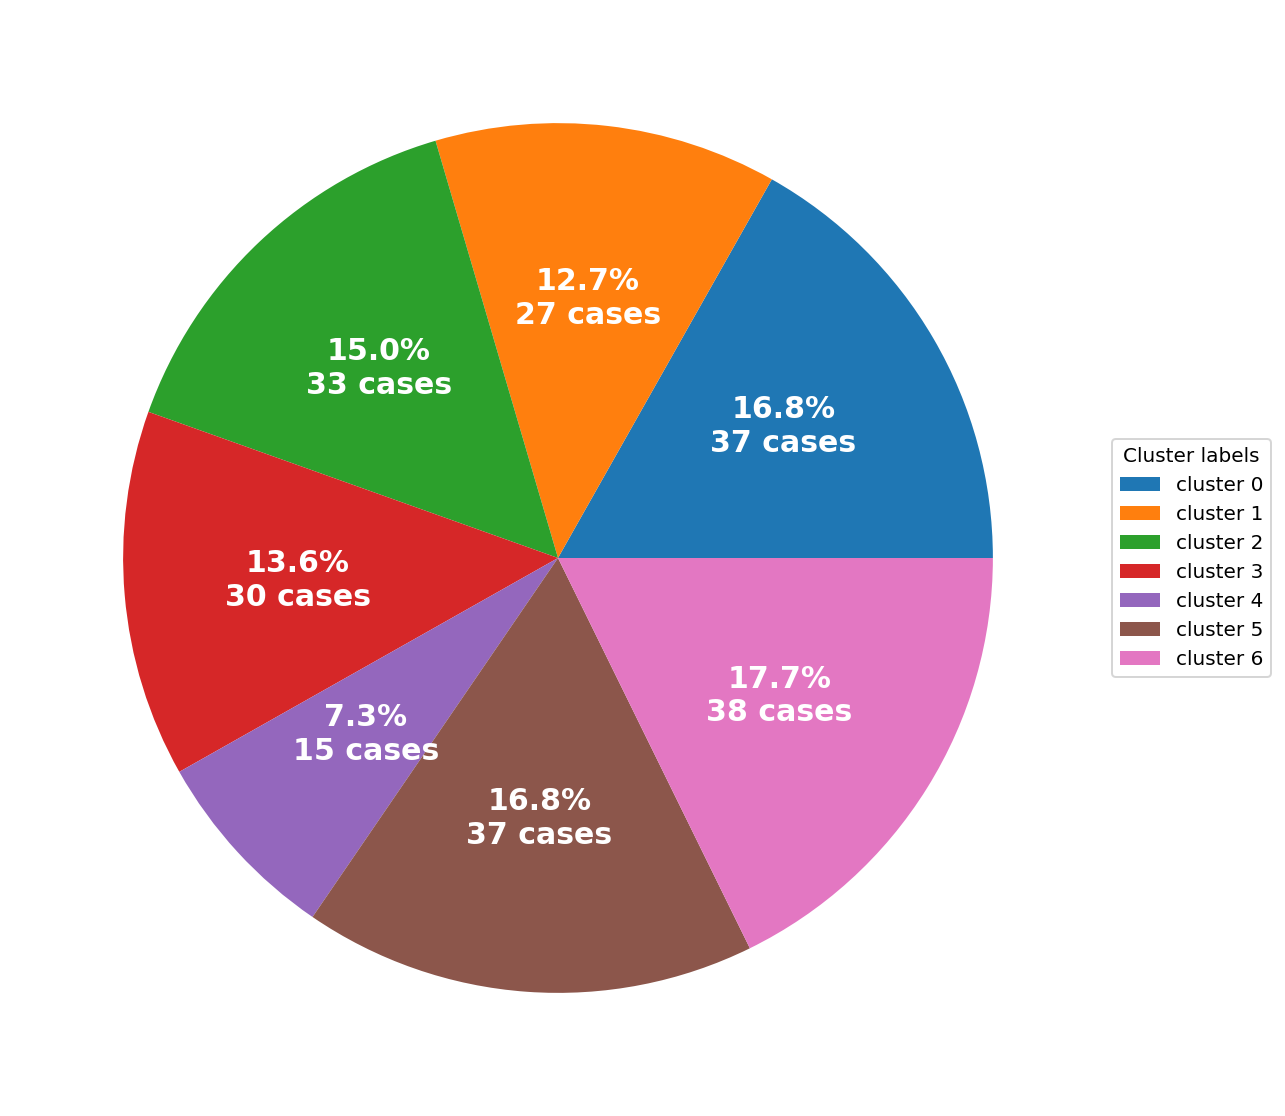

In [ ]:
N = 7
kmeans = KMeans(n_clusters = N, random_state = 41, n_jobs= -1).fit(tf_idf.values)
labels = kmeans.labels_
get_top_keywords(tf_idf, id_to_title,labels, vectorizer.get_feature_names(), 20)
show_top_keywords(X, labels, vectorizer.get_feature_names(), 20)
show_plot_result(tf_idf, id_to_title, labels)

In [ ]:
### visualization methods ###
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
### for plotting ###
import matplotlib.cm as cm

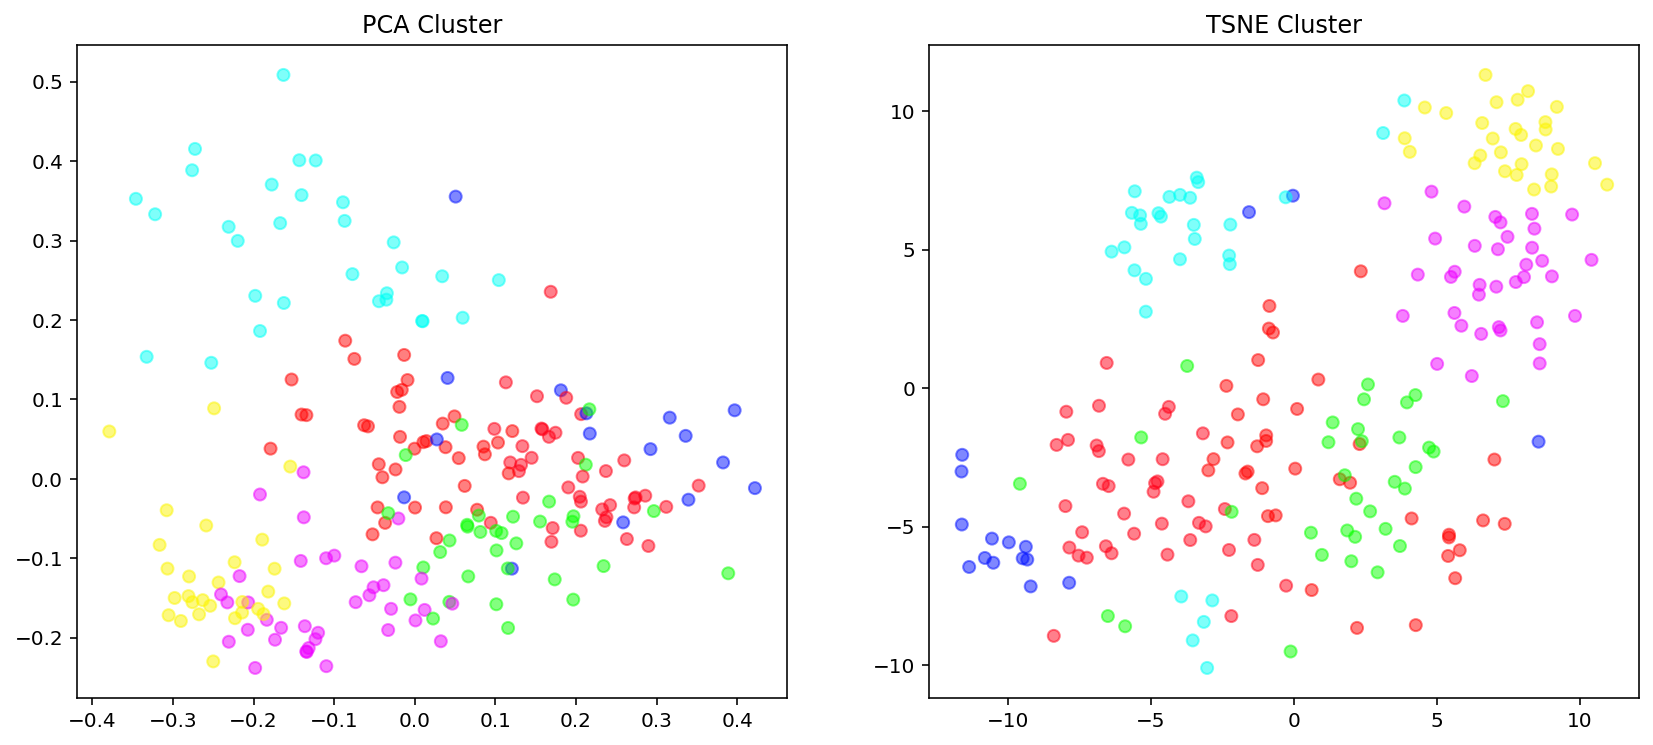

In [ ]:
def plot_tsne_pca(data, labels):
    '''
    This function plots the PCA and t-SNE on 2D plane.
    args:
        data: tf-idf weight matrix
        labels: predictions from K-means
    '''
    # initial set up and random pick up samples
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=len(labels), replace=False)
    
    '''
    pca (2000 x 2) : extract 2 eigenvectors that have the most explained variance
    tsne (2000 x 2) : feed the 50 principal components to t-SNE
    '''

    pca = PCA(n_components = 2).fit_transform(data[max_items, ])
    tsne =  TSNE().fit_transform(data[max_items, ])
        
    # random pick certain size of data points for visiualization
    idx = np.random.choice(range(pca.shape[0]), size=len(labels), replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # plot PCA
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset, alpha = .5)
    ax[0].set_title('PCA Cluster')
    
    # plot t-SNE
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset, alpha = .5)
    ax[1].set_title('TSNE Cluster')

    # plot PCA and t-SNE reduced data with above function
plot_tsne_pca(tf_idf.values,labels)

In [ ]:
native_2019 = pd.read_csv(os.path.join(SHINHAN_PATH, 'KCTI_NATIVE_ALL.txt'),
                          sep = '|', encoding = 'CP949')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
native_2019 = native_2019[['v1', 'v2', 'v3', 'gb2', 'cln_age_r', 'vlm']]
native_2019 = native_2019.groupby(['v1','v2','v3','gb2','cln_age_r']).sum().reset_index()

In [ ]:
#v3만 기준으로 하면 겹치는 경우가 있으므로, v2+v3를 더해서 지역 단위로 사용한다
native_2019['rel'] = ' '
except_rel = ['서울', '대전', '대구', '부산', '인천', '울산', '광주']
native_2019.loc[native_2019.v2.isin(except_rel), 'rel'] = native_2019.v2.astype(str) + ' ' + native_2019.v3.astype(str)
native_2019.loc[~native_2019.v2.isin(except_rel), 'rel'] = native_2019.v3.apply(lambda x : x[:-1] if x[-1] != '구' else x)
native_2019.rel.replace({'':'세종',
                         '인천 강화군' : '인천 강화',
                         '울산 울진군' : '울산 울진',
                         '부산 기장군' : '부산 기장',
                         '대구 달성군' : '대구 달서',
                         '울산 울주군' : '울산 울주',
                         '인천 옹진군' : '인천 옹진'}, 
                        inplace=True)

### 다음 소비에 대한 비율로 유사도를 결정합니다 --> 여행과 가장 관련 있는 항목만 선택 ###
gb2_feature = ['숙박', '외식', '종합쇼핑', '레저스포츠', '공연관람', '골프', '미술공예참여']
tourist_ALL_feature = native_2019[(native_2019.v1 != native_2019.v2) & (native_2019.gb2.isin(gb2_feature))]

In [ ]:
rel_to_convert = {i : j for i, j in zip(id_to_title.values(), id_to_title.keys())}

In [ ]:
def get_your_cluster(user_rel, labels, id_to_convert, rel_to_convert):
  rel_num = rel_to_convert[user_rel + ' 여행']
  user_cluster = labels[rel_num]
  return_rels = []
  idx,  = np.where(labels == user_cluster)
  for i in idx:
    return_rels.append(id_to_convert[i])
  return_rels = list(map(lambda x : x.replace(' 여행', ''), return_rels))
  return_rels.remove(user_rel) # remove user's input
  return return_rels, user_cluster

def find_sim_rel(user_vlm_ratio, tour_feature, in_cluster, age, features = gb2_feature):
  tour_feature = tour_feature[tour_feature.rel.isin(in_cluster) & (tour_feature.cln_age_r == age)]
  tour_feature = tour_feature.groupby(['rel','gb2']).sum().reset_index()
  tour_feature = tour_feature.pivot(index = 'gb2', columns = 'rel', values = 'vlm')
  tour_feature = tour_feature.reindex(index = features)
  tour_feature.reset_index(inplace=True)
  tour_feature.fillna(0, inplace=True)
  VLM_SUM = []
  DIST = []
  for rel in in_cluster:
    vlm_sum = tour_feature[rel].sum()
    VLM_SUM.append(np.log(vlm_sum))
    error = np.linalg.norm(tour_feature[rel].values/vlm_sum - user_vlm_ratio)
    DIST.append(error)
  result_sort = []
  WEIGHT = 1/(VLM_SUM/sum(VLM_SUM))
  weight_DIST = []
  for dist, weight in zip(DIST, WEIGHT):
    weight_DIST.append(dist * weight)
  
  for i in np.argsort(weight_DIST):
    result_sort.append(in_cluster[i])
  return result_sort

def show_label_keywords(data, clusters, labels, num, n_terms = 20):
    '''
    This function displays the top keywords based on tf-idf score.
    data = tf-idf array
    clusters = assigned cluster index
    labels = vectorizer.get_feature_names()
    n_terms = top n keywords
    '''
    #  based on predictions
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    fig, axes = plt.subplots(figsize = (10,10))
    

    x = [labels[t] for t in np.argsort(df.loc[num, :])[-n_terms:]]
    
    y = np.sort(df.loc[num, :])[-n_terms:][::-1]
    axes.bar(x, y, alpha = .5)
    axes.set_title('cluster {}'.format(num), fontsize = 20)
    axes.tick_params(labelsize = 13, labelrotation = 20)
    fig.show()

def show_city_with_age_vlm_ratio(tour_sum, variable, age, rels):
  fig = make_subplots()
  vis = tour_sum[tour_sum.rel.isin(rels) & (tour_sum.cln_age_r == age)]
  vis = vis.groupby(['rel', 'cln_age_r', 'gb2']).sum().reset_index()
  vis['ratio'] = 0
  for city in rels:
    city_total_vlm = sum(vis[vis.rel == city]['vlm'])
    vis.loc[vis[vis.rel == city].index, 'ratio'] = vis.loc[vis[vis.rel == city].index, 'vlm']/city_total_vlm

  fig = px.bar(vis, x = 'rel', y = 'ratio' , color = 'gb2',
              width = 10000,
            barmode = 'group')
  fig.update_layout(yaxis_title = 'vlm(%)',
                  xaxis_title = '지역',
                  title = '지역별 {} 비율 비교 - {}대'.format(variable, age),
                  height = 800, width = 800)


  fig.show() 

In [ ]:
def show_untact_tour(user_city, user_ratio, age, labels = labels, X = X, id_to_convert = id_to_title, rel_to_convert = rel_to_convert, tour_feature = tourist_ALL_feature, features = gb2_feature):
  blog_recommend, cluster_label = get_your_cluster(user_city, labels, id_to_title, rel_to_convert)
  vlm_sim_recommend = find_sim_rel(user_ratio, tour_feature, blog_recommend, age, features)
  print("blog crawling 결과와 소비 패턴의 유사도를 비교해보았을 때, 당신에게 다음의 5개 여행지를 추천합니다")
  print("-" * 100)
  for i, n in enumerate(vlm_sim_recommend[:5], 1):
    print("{}. {}".format(i, n))
  print("-" * 100)
  print("위 여행지들은 다음과 같은 특징을 갖습니다")
  print("1. 블로그 크롤링 결과")
  show_label_keywords(X, labels, vectorizer.get_feature_names(), cluster_label)
  print("-" * 100)
  print("2. 소비패턴 분석 결과")
  show_city_with_age_vlm_ratio(tour_feature, 'vlm', age, vlm_sim_recommend[:5])

In [ ]:
native_2019.rel.unique()

array(['강릉', '고성', '동해', '삼척', '속초', '양구', '양양', '영월', '원주', '인제', '정선',
       '철원', '춘천', '태백', '평창', '홍천', '화천', '횡성', '가평', '고양', '과천', '광명',
       '광주', '구리', '군포', '김포', '남양주', '동두천', '부천', '성남', '수원', '시흥', '안산',
       '안성', '안양', '양주', '양평', '여주', '연천', '오산', '용인', '의왕', '의정부', '이천',
       '파주', '평택', '포천', '하남', '화성', '거제', '거창', '김해', '남해', '밀양', '사천',
       '산청', '양산', '의령', '진주', '창녕', '창원', '통영', '하동', '함안', '함양', '합천',
       '경산', '경주', '고령', '구미', '군위', '김천', '문경', '봉화', '상주', '성주', '안동',
       '영덕', '영양', '영주', '영천', '예천', '울릉', '울진', '의성', '청도', '청송', '칠곡',
       '포항', '광주 광산구', '광주 남구', '광주 동구', '광주 북구', '광주 서구', '대구 남구',
       '대구 달서구', '대구 달서', '대구 동구', '대구 북구', '대구 서구', '대구 수성구', '대구 중구',
       '대전 대덕구', '대전 동구', '대전 서구', '대전 유성구', '대전 중구', '부산 강서구', '부산 금정구',
       '부산 기장', '부산 남구', '부산 동구', '부산 동래구', '부산 부산진구', '부산 북구', '부산 사상구',
       '부산 사하구', '부산 서구', '부산 수영구', '부산 연제구', '부산 영도구', '부산 중구',
       '부산 해운대구', '서울 강남구', '서울 강동구', '서울 강북구', '서울 강서구', '서

[36.35780575 38.45088968 35.9653292  37.60184285 34.75324929 35.60072534
 37.85738018 36.00394491 36.32665979 35.93047638 33.60972373 34.46276118
 35.00085223 37.84320331 36.10858739 34.72670132 35.21207018 37.27285218
 34.93385391 36.57933312 37.73615589 36.11376167 35.8109967  36.61048744
 34.55998392 34.87799474 36.12080174 39.42780598 36.35522064 39.18722676
 36.49374294 33.96968674 32.85139254 35.62420227 37.00357705 34.78861453]
[16.219058732294357, 15.097477135978462, 15.185428591558592, 10.415539159268974, 15.935192305948245, 14.893772753815977, 13.735048484348047, 15.600624212805172, 16.117765372659623, 17.074769864839997, 21.912320980083205, 15.567103218805487, 14.682754321407515, 15.761228174425513, 22.189956070367323, 10.815482178740279, 14.225317839735762, 11.960715771487179, 14.688529967387554, 18.31714253225718, 19.87761660946183, 13.206358869914999, 13.419417248845239, 10.957706288276269, 14.772227420665518, 9.629089926280743, 15.343809699390288, 13.255949632210472, 15.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44536 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47532 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 51600 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44592 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 50696 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 49240 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 47560 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotli

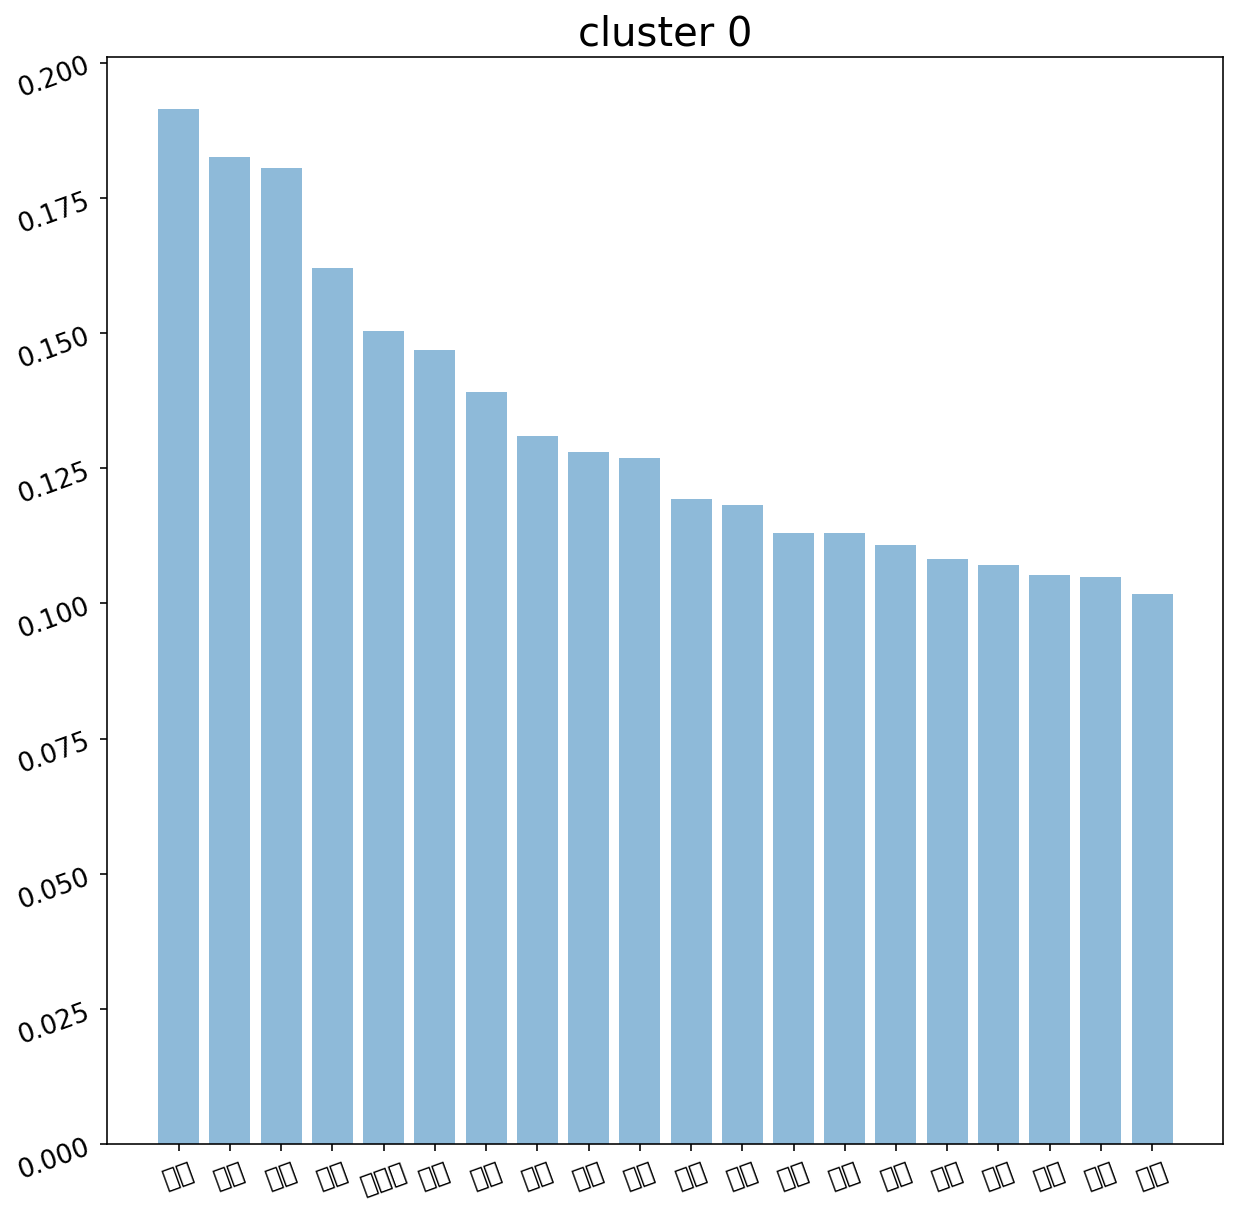

In [ ]:
## USER'S INPUT ##


##본래 가고 싶었던 여행지
WANNA_CITY = '담양'

### 이용자의 연령대
USERS_AGE = 30


#'숙박', '외식', '종합쇼핑', '레저스포츠', '공연관람', '골프', '미술공예참여'에 대한 소비를 얼마나 하시나요?
rooms = 5       #숙박비로 사용하는 금액
food = 7        #외식비로 사용하는 금액
shopping = 3   #쇼핑으로 사용하는 금액
leisure = 3     #레저스포츠로 사용하는 금액
perform = 2     #공연관람으로 사용하는 금액
golf = 0        #골프로 사용하는 금액
art = 2         #미술 공예 참여로 사용하는 금액

# 지역 vlm ratio와의 비교를 위해 USER INPUT도 ratio로 바꾼다
user_ratio = np.array([rooms, food, shopping, leisure, perform, golf, art]) / sum([rooms, food, shopping, leisure, perform, golf, art])

show_untact_tour(WANNA_CITY, user_ratio, USERS_AGE)

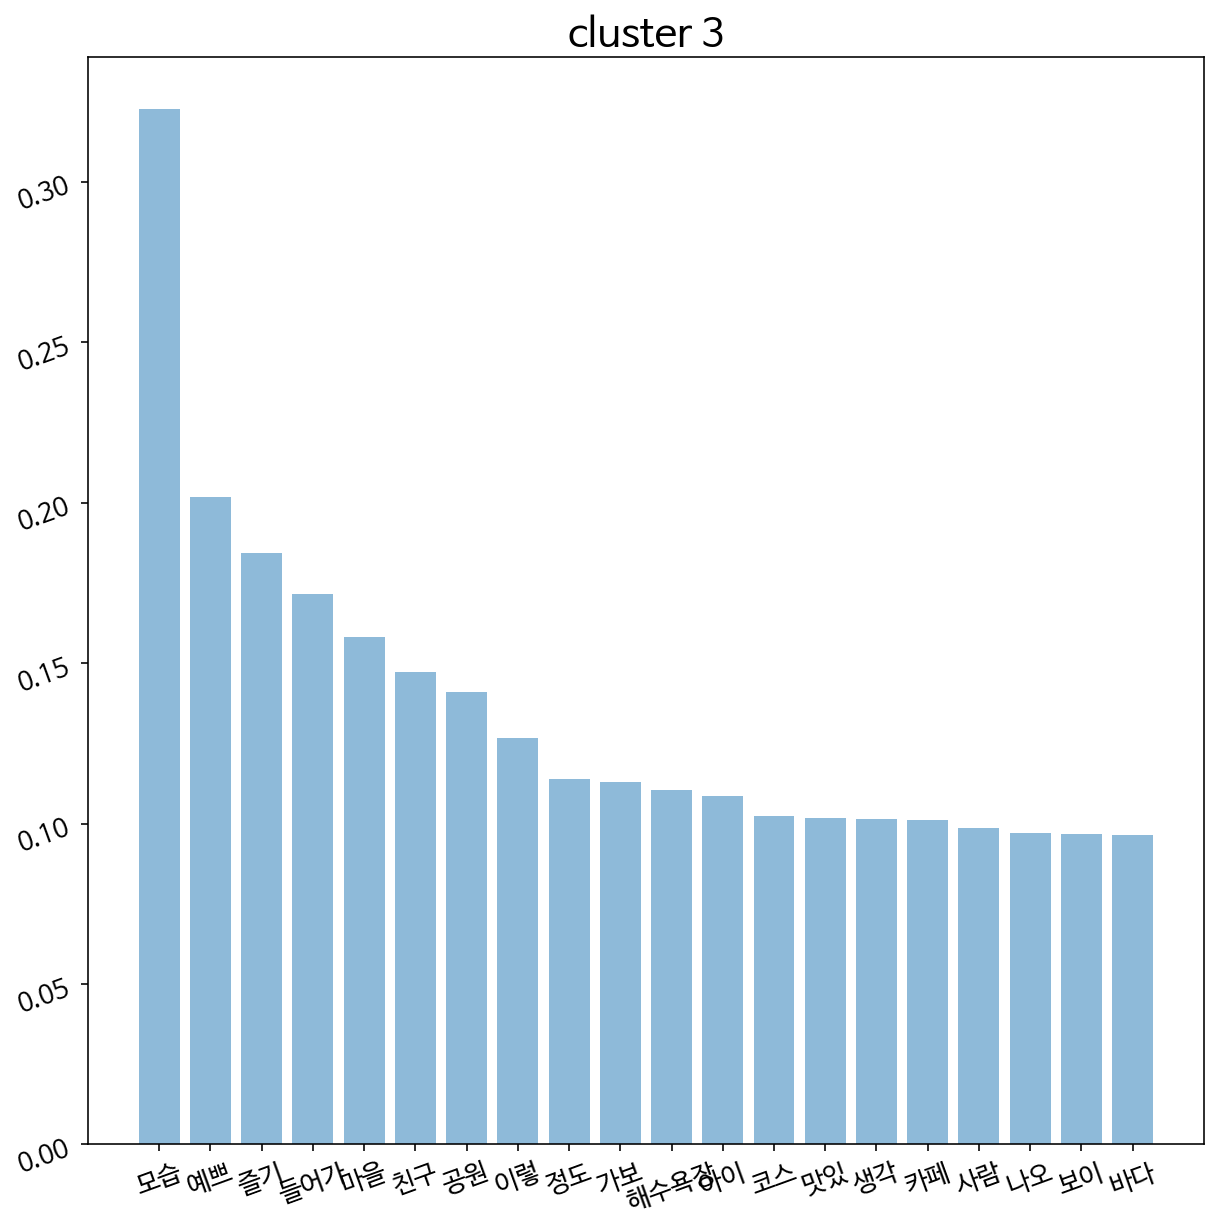

In [ ]:
show_label_keywords(X, labels,  vectorizer.get_feature_names(), 3)

In [ ]:
with open(os.path.join(PKL_PATH, "PKL_LIST1.pkl"), "rb") as f:
  YOUR_PKL = pickle.load(f)
with open(os.path.join(PKL_PATH, "PKL_LIST2.pkl"), "rb") as f:
  YOUR_PKL += pickle.load(f)
with open(os.path.join(PKL_PATH, "PKL_LIST3.pkl"), "rb") as f:
  YOUR_PKL += pickle.load(f)

In [ ]:
YOUR_PKL = list(map(lambda x : normalize('NFC', x), YOUR_PKL))
set(YOUR_PKL) - set(CITY)

{'청도 여행', '파주 여행'}